# Learning an Image Classification Model from Scratch


<!-- [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/noportman/mitxpro/blob/main/files/image_classification.ipynb) -->

![Python](https://img.shields.io/badge/Python-3.10-blue)
![TensorFlow](https://img.shields.io/badge/TensorFlow-2.x-orange?logo=tensorflow)
![Keras](https://img.shields.io/badge/Keras-Deep%20Learning-red?logo=keras)
![NumPy](https://img.shields.io/badge/NumPy-Numerical%20Computing-orange?logo=numpy)
![Pandas](https://img.shields.io/badge/Pandas-Data%20Wrangling-lightgrey?logo=pandas)
![Matplotlib](https://img.shields.io/badge/Matplotlib-Data%20Viz-blue?logo=matplotlib)

![Status](https://img.shields.io/badge/Status-Completed-brightgreen)
![License](https://img.shields.io/badge/License-MIT-yellow)

## The Fashion MNIST dataset

The [fashion_mnist](https://github.com/zalandoresearch/fashion-mnist) dataset consists of 70,000 images of clothing items across 10 categories.

![Fashion](https://production-media.paperswithcode.com/datasets/Fashion-MNIST-0000000040-4a13281a_m8bp4wm.jpg)

Luckily for us, this dataset is available in a convenient format through Keras, so we will load it and take a look.

But first, let's get the usual technical preliminaries out of the way.

As we did previously, we will first import the following packages and set the seed for the random number generator.


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
# keras.utils.set_random_seed(42)
tf.random.set_seed(42)

With the technical preliminaries out of the way, let's load the dataset and take a look.

In [2]:
#load data into x_train, y_train, x_test, y_test

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


There are 60,000 images in the training set, each of which is a 28x28 matrix.

In [4]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


The remaining 10,000 images are in the test set.

---
OK, let's look at the first 10 rows of the dependent variable  𝑦 .


In [5]:
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

What do these numbers mean?

According to the [fashion_mnist Github site](https://github.com/zalandoresearch/fashion-mnist), this is what each number 0-9 corresponds to:

| Label | Description   |
|-------|---------------|
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |


Create a little Python list so that we can go from numbers to descriptions easily.

In [6]:
#Call the list "labels"

labels = ["T-shirt/top",
          "Trouser",
          "Pullover",
          "Dress",
          "Coat",
          "Sandal",
          "Shirt",
          "Sneaker",
          "Bag",
          "Ankle boot"]

Given a number, the description is now a simple look-up. Let's see what the very first training example is about.

In [7]:
labels[y_train[0]]

'Ankle boot'

The very first image is an "Ankle boot"!

Let's take a look at the raw data for the image.

In [8]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

Let's look at the first 25 images using the handy `plt.imshow()` command

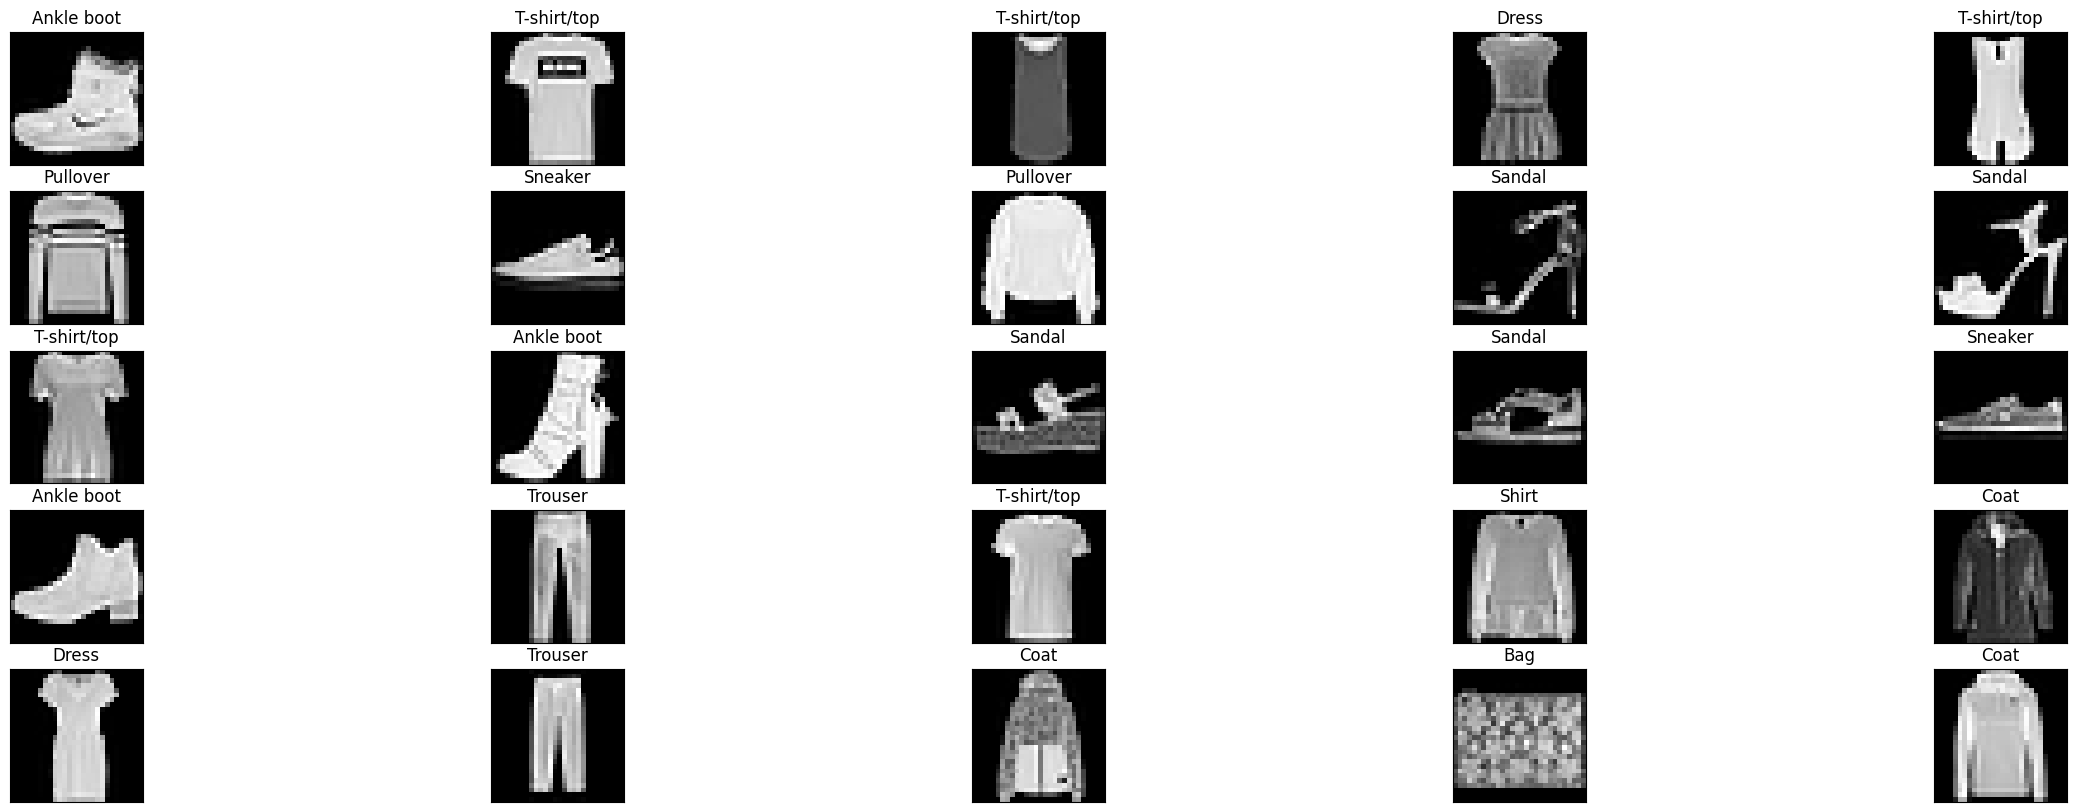

In [9]:
# You'll create two variables namely "fig" and "ax" as shown in the screencast.

fig = plt.figure(figsize=(30, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.set_title(f"{labels[y_train[i]]}")
    ax.imshow(x_train[i], cmap="gray")

The images are a bit small but they will do for now.

## A NN Model - First Attempt



Our first NN will be a simple one with a single hidden layer.



### Data Prep



Tip: NNs learn best when each independent variable is in a small range. So, standardize them by either

- subtracting the mean and dividing by the standard deviation or
- if they are in a guaranteed range, just divide by the max value.

The inputs here range from 0 to 255. Let's normalize to the 0-1 range by dividing everything by 255.

In [10]:
#Standardize x_train and x_test

x_train = x_train/ 255.0
x_test = x_test/ 255.0

### Define Model in Keras

As we saw in the previous module, creating an NN is usually just a few lines of Keras code.

- The input will be 28 x 28 matrices of numbers. These will have to be flattened into a long vector and then fed to the hidden layer.
- We will start with a single hidden layer of 256 ReLU neurons.
- Since this is a multi-class classification problem (e.g., we need to predict one of 10 clothing categories), the output layer has to produce a 10-element vector of probabilities that sum up to 1.0 => we will use the softmax layer that we learned about in the previous lecture.

In [11]:
# define the input layer
input = keras.Input(shape=(28,28))

# convert the 28 x 28 matrix of numbers into a long vector
h = keras.layers.Flatten()(input)

# feed the long vector to the hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden")(h)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(10, activation="softmax", name="Output")(h)

# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden (Dense)                  │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,530 (795.04 KB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

Let's hand-calculate the number of parameters to verify.

In [13]:
# calculate the number of parameters and set the output to "parameters"

parameters = (784 * 256 + 256) + (256 * 10 + 10)

print(parameters)

203530


### Set Optimization Parameters

Now that the model is defined, we need to tell Keras three things:

- What loss function to use
- Which optimizer to use - we will again use Adam which is an excellent set-and-forget choice
- What metrics you want Keras to report out - in classification problems like this one, Accuracy is usually the metric you want to see.

Since our output variable is categorical with 10 levels, we will select the `sparse_categorical_crossentropy` loss function.

In [14]:
# Compile your model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Train the Model!

- The batch size: 32 or 64 are commonly used
- The number of epochs i.e., how many passes through the training data: start with 10-20.


---

OK, let's train the model using the `model.fit` function!

In [15]:
# fit your model first try with a batch size of 32 and 10 epochs

batch_size = 64
epochs = 10

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/10
938/938 - 5s - 5ms/step - accuracy: 0.8240 - loss: 0.4990
Epoch 2/10
938/938 - 4s - 5ms/step - accuracy: 0.8652 - loss: 0.3746
Epoch 3/10
938/938 - 5s - 5ms/step - accuracy: 0.8783 - loss: 0.3342
Epoch 4/10
938/938 - 4s - 4ms/step - accuracy: 0.8869 - loss: 0.3078
Epoch 5/10
938/938 - 4s - 5ms/step - accuracy: 0.8939 - loss: 0.2894
Epoch 6/10
938/938 - 5s - 6ms/step - accuracy: 0.8996 - loss: 0.2727
Epoch 7/10
938/938 - 5s - 5ms/step - accuracy: 0.9047 - loss: 0.2586
Epoch 8/10
938/938 - 4s - 4ms/step - accuracy: 0.9100 - loss: 0.2461
Epoch 9/10
938/938 - 5s - 5ms/step - accuracy: 0.9130 - loss: 0.2349
Epoch 10/10
938/938 - 5s - 5ms/step - accuracy: 0.9168 - loss: 0.2251


### Evaluate the

You can see from the above that our model achieves over 91% accuracy on the train set but, as we know, doing well on the training set isn't all that impressive due to the possibility of overfitting. So the real question is how well does it do on the test set?

`model.evaluate` is a very handy function to calculate the performance of your model on any dataset.

In [17]:
# Evaluate model on test data set
model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - 2ms/step - accuracy: 0.8797 - loss: 0.3538


[0.3537953495979309, 0.8797000050544739]



---

Did the NNs we create take advantage of the fact that the input data is images?

## A Convolutional Neural Network

## Convolutional Layers

Convolutional (typically abbreviated to "conv") layers were the key breakthrough that led to all the exciting advances in AI for Computer Vision problems like Image Classification, Image Recognition etc. They were designed to specifically work with images.

Conv layers are the reason why your iPhone can recognize your face!

We will follow the same sequence of steps as we did above:

- Data Prep
- Define Model
- Set Optimization Parameters
- Train Model
- Evaluate Model

## Data Prep

The data has already been normalized so that the numbers are between 0 and 1. We don't need to do it again.

In [18]:
x_train.shape

(60000, 28, 28)

For reasons that will become clear when you work with color images, we also need to add another dimension to each example so that it goes from 28x28 to 28x28x1

In [19]:
# add another dimension to x_train and x_test

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [20]:
x_train.shape

(60000, 28, 28, 1)

## Define Model

OK, we are ready to create our very first **Convolutional Neural Network (CNN)!**

In [ ]:
input = keras.Input(shape=x_train.shape[1:])

# first convolutional block
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(input) # convolutional layer
x = keras.layers.MaxPool2D()(x) # pooling layer

# second convolutional block
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(x) # convolutional layer
x = keras.layers.MaxPool2D()(x) # pooling layer

#Flatten the layers
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation="relu")(x)

# create an output called "output"
output = keras.layers.Dense(10, activation="softmax")(x)

model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_1 (Conv2D)                      │ (None, 27, 27, 32)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_2 (Conv2D)                      │ (None, 12, 12, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,026 (1.15 MB)

 Trainable params: 302,026 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

## Set Optimization Parameters

In [ ]:
# Compile model using sparse_categorical_crossentropy
# and adam, and accuracy as a metric
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## Train the Model

DISCLAIMER: This will take some time to complete

In [ ]:
# Train the model with either 32 or 64 as the batch size and using 10 epochs

model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=2)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.7681 - loss: 0.6519
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.8799 - loss: 0.3318
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.8982 - loss: 0.2799
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9085 - loss: 0.2480
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9183 - loss: 0.2239
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.9246 - loss: 0.2032
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.9307 - loss: 0.1835
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 37ms/step - accuracy: 0.9386 - loss: 0.1661
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.9444 - loss: 0.1489
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.9511 - loss: 0.1333


## Evaluate the Model

In [ ]:
# Get the score of the model
score = model.evaluate(x_test, y_test, verbose=2)   
print("Test accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9045 - loss: 0.3185
Test accuracy: 0.9061999917030334


Back to Fashion MNIST. Let's see what the [state of the art (SOTA)](https://www.google.com/url?q=https%3A%2F%2Fpaperswithcode.com%2Fsota%2Fimage-classification-on-fashion-mnist) accuracy is.

It is **96.91%!**

**Challenge: Can you get to SOTA by playing around with the architecture of the network?**

## Conclusion
We have built a Deep Learning model that can classify grayscale images of clothing items with over 90% accuracy!!